Part 1: Training Script

In [ ]:
# ==========================================
# PART 1: THE TRAINING SCRIPT
# This script creates 'svm_product_classifier.pkl'
# ==========================================

import pandas as pd
import numpy as np
import requests
import re
import random
import joblib
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# 1. CONFIGURATION
TAXONOMY_URL = "http://www.google.com/basepages/producttype/taxonomy.en-US.txt"
DATASET_SIZE = 30000  # Number of rows to generate for training
MODEL_FILENAME = 'svm_product_classifier.pkl'

def download_taxonomy(url):
    print("Step 1: Downloading Google Taxonomy...")
    response = requests.get(url)
    # Filter for categories that have at least one '>' to get depth
    categories = [line.strip() for line in response.text.split('\n') if '>' in line]
    print(f" -> Found {len(categories)} categories.")
    return categories

def generate_synthetic_data(categories, n_rows):
    print(f"Step 2: Generating {n_rows} rows of training data...")
    adjectives = ["Premium", "Vintage", "Professional", "Luxury", "Organic", "Durable"]
    brands = ["Acme", "Apex", "Zenith", "Global", "Elite"]

    data = []
    # We use a subset of categories (first 300) to keep the file size manageable for Colab
    active_cats = categories[:300]

    for _ in range(n_rows):
        cat_path = random.choice(active_cats)
        leaf = cat_path.split('>')[-1].strip()
        clean_leaf = re.sub(r'[^a-zA-Z0-9\s]', '', leaf)

        # Create a title: "Brand Adjective Product"
        title = f"{random.choice(brands)} {random.choice(adjectives)} {clean_leaf}"
        data.append({"title": title, "category": cat_path})

    return pd.DataFrame(data)

# --- EXECUTION START ---

# Get the labels
all_categories = download_taxonomy(TAXONOMY_URL)

# Create the data
df = generate_synthetic_data(all_categories, DATASET_SIZE)

# Define the Scalable SVM Pipeline
# We use SGDClassifier because it's built for Big Data and high speed
print("Step 3: Training the SVM Model (this may take a minute)...")

svm_model = SGDClassifier(
    loss='hinge',           # This makes it a Linear SVM
    penalty='l2',           # Regularization to prevent overfitting
    max_iter=1000,
    tol=1e-3,
    random_state=42
)

# CalibratedClassifierCV allows the SVM to give us "Confidence %"
calibrated_svm = CalibratedClassifierCV(svm_model, cv=3, method='sigmoid')

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('clf', calibrated_svm)
])

# Train
pipeline.fit(df['title'], df['category'])

# Save the file
print(f"Step 4: Saving model to {MODEL_FILENAME}...")
joblib.dump(pipeline, MODEL_FILENAME)

print("\nSUCCESS! The file 'svm_product_classifier.pkl' has been created.")
print("You can now see it in the folder icon on the left.")

Step 1: Downloading Google Taxonomy...
 -> Found 5574 categories.
Step 2: Generating 30000 rows of training data...
Step 3: Training the SVM Model (this may take a minute)...
Step 4: Saving model to svm_product_classifier.pkl...

SUCCESS! The file 'svm_product_classifier.pkl' has been created.
You can now see it in the folder icon on the left.


step 2 : Create the app.py file

In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np

# Page config
st.set_page_config(page_title="Big Data Product Classifier", page_icon="🏷️")

@st.cache_resource
def load_model():
    # Loading our trained SVM model
    return joblib.load('svm_product_classifier.pkl')

st.title("🏷️ Smart Product Categorizer")
st.markdown("This tool uses a **Linear SVM** to classify products into Google's taxonomy.")

try:
    model = load_model()

    user_input = st.text_input("Enter a Product Title:", placeholder="e.g. Luxury Leather Handbag")

    if user_input:
        # Prediction
        prediction = model.predict([user_input])[0]

        # Get confidence score
        probabilities = model.predict_proba([user_input])[0]
        confidence = np.max(probabilities)

        # Display results
        st.divider()
        col1, col2 = st.columns(2)

        with col1:
            st.metric("Predicted Category", prediction.split('>')[-1])
            st.caption(f"Full Path: {prediction}")

        with col2:
            st.metric("Confidence Score", f"{confidence:.2%}")

        with st.expander("Show alternative matches"):
            top_3_idx = np.argsort(probabilities)[-3:][::-1]
            for idx in top_3_idx:
                st.write(f"- {model.classes_[idx]} ({probabilities[idx]:.2%})")

except FileNotFoundError:
    st.error("Model file 'svm_product_classifier.pkl' not found! Please run your training script cell first.")

Writing app.py


install streamlit

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.7 MB/s eta 0:00:00


asks for the "Tunnel Password,

In [ ]:
!curl ipv4.icanhazip.com

34.182.29.192


Install Localtunnel

In [ ]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 5s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹npm notice
npm notice New major version of npm available! 10.8.2 -> 11.7.0
npm notice Changelog: https://github.com/npm/cli/releases/tag/v11.7.0
npm notice To update run: npm install -g npm@11.7.0
npm notice
⠹

Run the App and the Tunnel together

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧

⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.182.29.192:8501

your url is: https://early-dogs-sit.loca.lt


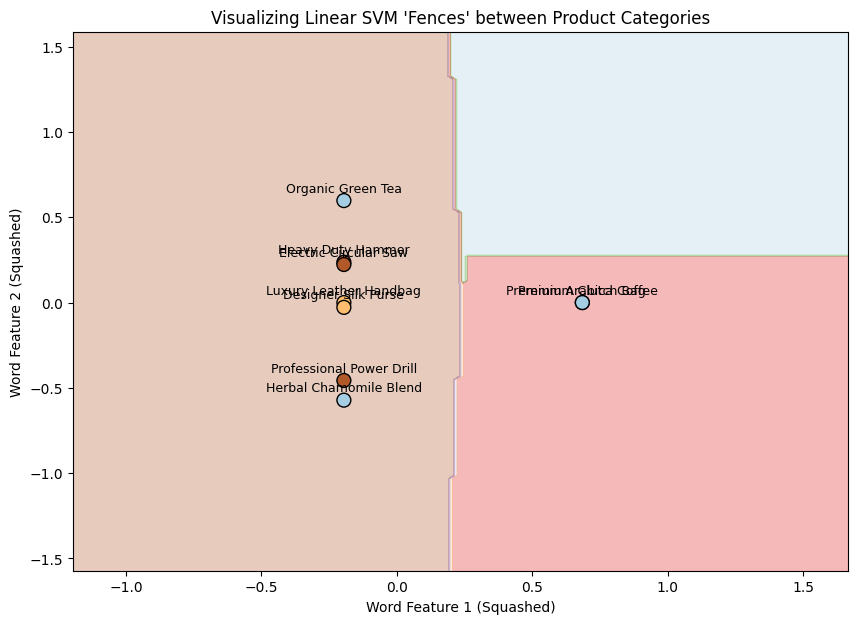

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# 1. Create a tiny, simplified dataset for visualization
data = {
    'title': [
        "Luxury Leather Handbag", "Designer Silk Purse", "Premium Clutch Bag", # Fashion
        "Professional Power Drill", "Heavy Duty Hammer", "Electric Circular Saw", # Tools
        "Organic Green Tea", "Premium Arabica Coffee", "Herbal Chamomile Blend"  # Beverages
    ],
    'category': ['Fashion', 'Fashion', 'Fashion', 'Tools', 'Tools', 'Tools', 'Beverages', 'Beverages', 'Beverages']
}
df = pd.DataFrame(data)

# 2. Convert text to numbers (TF-IDF)
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['title']).toarray()
y = df['category'].astype('category').cat.codes # Convert categories to numbers (0, 1, 2)

# 3. PCA: Squash the data from many dimensions down to 2D so we can plot it
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf)

# 4. Train a Linear SVM on the 2D data
# We use a linear kernel to see the straight "fences"
model = SVC(kernel='linear')
model.fit(X_pca, y)

# 5. Create a "Decision Surface" (The shaded areas)
h = .02 # step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 6. Plotting
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3) # Shaded areas

# Plot the actual products as dots
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=100, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Visualizing Linear SVM 'Fences' between Product Categories")
plt.xlabel("Word Feature 1 (Squashed)")
plt.ylabel("Word Feature 2 (Squashed)")

# Add labels to the dots
for i, txt in enumerate(df['title']):
    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1] + 0.05), fontsize=9, ha='center')

plt.show()